# Intraday Trading via Day Trading Techniques & Indicators
---

### Data collected via AlphaVantage free API using extended intraday data. 
> https://www.alphavantage.co/documentation/

---

# 00 - Data Collection

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read in sample Data

**First, we want to ensure our data is in the proper form and there is no extra cleaning that needs to be done. For this we will look at our most recent dataset.**

In [2]:
df = pd.read_csv('../01_Data/extended_intraday_SPY_1min_year1month1_adjusted.csv')
df.head()

,time,open,high,low,close,volume
0,2021-10-15 20:00:00,445.97,445.97,445.87,445.87,1078
1,2021-10-15 19:59:00,445.91,445.91,445.88,445.88,641
2,2021-10-15 19:58:00,445.90,445.90,445.88,445.88,774
3,2021-10-15 19:56:00,445.88,445.88,445.88,445.88,152
4,2021-10-15 19:54:00,445.92,445.94,445.92,445.94,1383


**We want our index to be the 'time' columns and make sure it is in the form of a DateTime object.**

In [3]:
df.set_index(pd.DatetimeIndex(df['time']), inplace=True)
df.drop(columns = ['time'], inplace = True)
df.head()

,open,high,low,close,volume
time,,,,,
2021-10-15 20:00:00,445.97,445.97,445.87,445.87,1078
2021-10-15 19:59:00,445.91,445.91,445.88,445.88,641
2021-10-15 19:58:00,445.90,445.90,445.88,445.88,774
2021-10-15 19:56:00,445.88,445.88,445.88,445.88,152
2021-10-15 19:54:00,445.92,445.94,445.92,445.94,1383


**We shouldn't have any null values given how the data was acquired, but we should always check.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18015 entries, 2021-10-15 20:00:00 to 2021-09-17 04:01:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    18015 non-null  float64
 1   high    18015 non-null  float64
 2   low     18015 non-null  float64
 3   close   18015 non-null  float64
 4   volume  18015 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 844.5 KB


In [5]:
df.describe()

,open,high,low,close,volume
count,18015.000000,18015.000000,18015.000000,18015.00000,1.801500e+04
mean,436.866990,436.944513,436.793063,436.86720,1.081089e+05
std,4.697034,4.681832,4.711518,4.69626,2.131648e+05
min,426.160000,426.190000,425.650000,426.15000,1.000000e+02
25%,433.970000,434.050000,433.850000,433.97000,1.851000e+03
50%,436.140000,436.210000,436.080000,436.14000,2.784400e+04
75%,440.659950,440.720000,440.565000,440.65000,1.415125e+05
max,447.020000,447.020000,446.170000,446.21000,6.217633e+06


**Finally, our data should be for the most recent month period, from 9/17 to 10/17 as of the date it was acquired. Furthermore it should include off-hours data.**

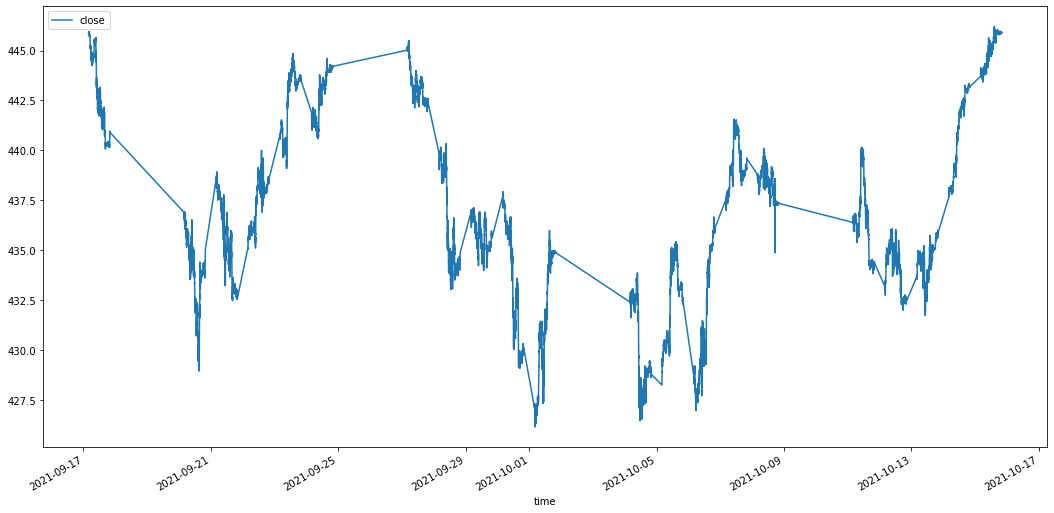

In [6]:
df[['close']].plot(figsize=(18,9));

**Everything seems in order. These 'straight lines' extending from untracked overnight and weekends will likely need to be removed in order to preserve the integrity of our derived columns in the future; ex. VWAP and other Moving Averages.**

# Read in all Datasets

**We have 2 years worth of data in the form of year1month1 referring to 1 month prior and year2month12 referring to 2 years prior, with each dataset containing 1 month of prices and volume for SPY.** 

In [7]:
# Year we want
y = 1
# Month we want; we already imported month 1 above
m = 2

while (y < 3) and (m < 13):
    temp = pd.read_csv('../01_Data/extended_intraday_SPY_1min_year' + str(y) + 'month' + str(m) + '_adjusted.csv')
    temp.set_index(pd.DatetimeIndex(temp['time']), inplace=True)
    temp.drop(columns = ['time'], inplace = True)
    
    df = pd.concat([df, temp])
    
    if (y == 1) and (m == 12):
        y = 2
        m = 0
    
    m += 1

df.shape

(411267, 5)

**Shape appears to be correct given size of individual datasets.**

**To be sure, let's plot the data.**

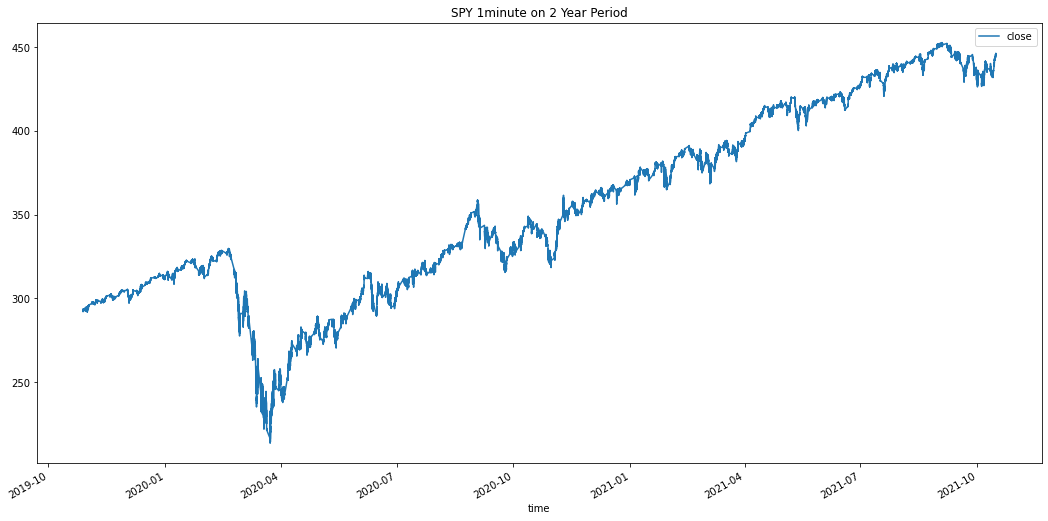

In [8]:
df[['close']].plot(figsize=(18,9), title='SPY 1minute on 2 Year Period');

**When compared to a graph found on TradingView, or any online resource, we see that this graph does represent the SPDR S&P500 ETF TRUST (SPY)**
> Therefore we know our data was imported correctly

---

# Sort Index

**Currently our dataframe starts at our most recent date and moves backwards. This will cause issue with moving averages we want to make so we need to sort our index so the earliest dates are first.**

In [9]:
df = df.sort_index()
df.head(25)

,open,high,low,close,volume
time,,,,,
2019-10-28 04:01:00,292.170418,292.170418,292.170418,292.170418,581
2019-10-28 04:02:00,292.151078,292.151078,292.141408,292.141408,300
2019-10-28 04:05:00,292.238108,292.238108,292.238108,292.238108,300
2019-10-28 04:06:00,292.257448,292.257448,292.228438,292.228438,300
2019-10-28 04:07:00,292.286458,292.286458,292.286458,292.286458,100
2019-10-28 04:08:00,292.228438,292.228438,292.209098,292.209098,1260
2019-10-28 04:12:00,292.228438,292.228438,292.209098,292.209098,226
2019-10-28 04:15:00,292.421839,292.489529,292.421839,292.421839,1703
2019-10-28 04:16:00,292.354149,292.354149,292.354149,292.354149,412


**Let's make sure there were no unintended consequences**

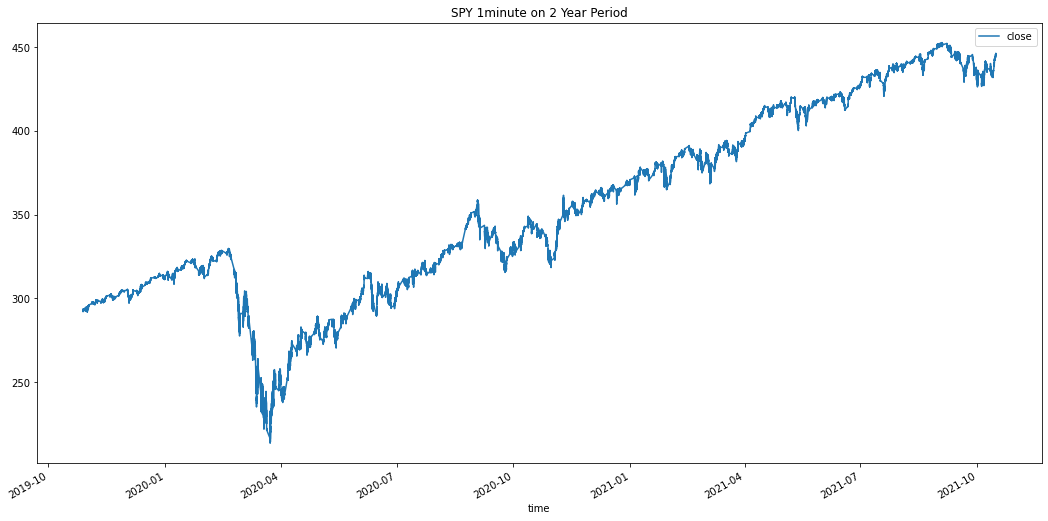

In [10]:
df[['close']].plot(figsize=(18,9), title='SPY 1minute on 2 Year Period');

**Looks good.**

# Save Combined Dataset

In [11]:
df.to_csv('../01_Data/extended_intraday_SPY_1min_combined.csv')